In [1]:
from zipfile import ZipFile
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from geopandas import GeoDataFrame
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
from geopy.distance import geodesic

In [3]:
import pandas as pd
import zipfile
import re
import os 

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')

# Loading incident data 
zf = zipfile.ZipFile('Data_incidents.csv.zip') 
df = pd.read_csv('Data_incidents.csv.zip')


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# For density plot at the bottom 
mass_shootings = df[df['Mass Shooting']==True].reset_index()
#mass_shootings[mass_shootings['Date']='']

In [5]:
# Loading law data 
df_law = pd.read_csv('gun_law_merge.csv', sep = ';')

# Renaming the state column
df_law.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [6]:
#import fiona; help(fiona.open)

In [7]:
# Loading map data 

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/maps/states_21basic')

usa = gpd.read_file('states.shp')
usa.head(2)
#len(usa.STATE_NAME.unique())

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."


### Grouping the incident data by sum and count depending on what we want

In [8]:
df_group_count=df.groupby('state').count().reset_index()
df_group_incidents_count = df_group_count[['state','incident_id']]
df_group_sum = df.groupby('state').sum().reset_index()
df_group_incidents_sum = df_group_sum[['state','n_killed','n_injured']]
df_group_incidents_sum.head(1)

# Dataset with N_incident, n_killed and n_injured
df_group_incidents = df_group_incidents_sum.set_index('state').join(df_group_incidents_count.set_index('state')).reset_index()

### Grouping the incident data by number of true in incident characteristics

In [9]:
df_IC = df.iloc[:, [2] + list(range(19,128))]
df_IC_group = df_IC.groupby('state').sum().reset_index()

for col in df_IC.columns: 
    print(col)

state
Shot - Wounded/Injured
Mass Shooting
Possession
Possession of gun by felon or prohibited person
Shot - Dead
Gang involvement
Shots Fired - No Injuries
Bar/club incident - in or around establishment
Officer Involved Incident
Officer Involved Shooting - subject/suspect/perpetrator killed
Drug involvement
Kidnapping/abductions/hostage
Under the influence of alcohol or drugs
Suicide
Murder/Suicide
Attempted Murder/Suicide
Domestic Violence
Home Invasion
Home Invasion - Resident killed
Armed robbery with injury/death and/or evidence of DGU found
Drive-by
Officer Involved Shooting - Officer shot
Officer Involved Shooting - Officer killed
Officer Involved Shooting - subject/suspect/perpetrator shot
Officer Involved Shooting - subject/suspect/perpetrator suicide at standoff
Spree Shooting
Institution/Group/Business
Animal shot/killed
Home Invasion - Resident injured
Mass Murder
Concealed Carry License - Perpetrator
Stolen/Illegally owned
School Incident
School Shooting - university/colle

### Editing law data

In [10]:
laws =['State permit required to purchase? - Long guns',
'Firearm registration? - Long guns',
'Owner license required? - Long guns',
'Assault weapon law? - Long guns',
'NFA weapons restricted? - Long guns',
'Background checks required for private sales? - Long guns',
'Magazine Capacity Restriction? - Long guns',
'Red flag law? - Long guns',
'State permit required to purchase? - Handguns',
'Firearm registration? - Handguns',
'Owner license required? - Handguns',
'Assault weapon law? - Handguns',
'NFA weapons restricted? - Handguns',
'Background checks required for private sales? - Handguns',
'Magazine Capacity Restriction? - Handguns',
'Red flag law? - Handguns']

laws_longguns = laws[0:8]
laws_handguns = laws[8:16]

print(len(laws_longguns))
print(len(laws_handguns))


#count how many laws on handguns and longgund each state has

df_law['handgun_laws - count'] = df_law.loc[:, laws_handguns].sum(axis=1)
df_law['longgun_laws - count'] = df_law.loc[:, laws_longguns].sum(axis=1)
df_law.head(1)

8
8


,state,State permit required to purchase? - Long guns,Firearm registration? - Long guns,Owner license required? - Long guns,Assault weapon law? - Long guns,NFA weapons restricted? - Long guns,Background checks required for private sales? - Long guns,Magazine Capacity Restriction? - Long guns,Red flag law? - Long guns,State permit required to purchase? - Handguns,Firearm registration? - Handguns,Owner license required? - Handguns,Assault weapon law? - Handguns,NFA weapons restricted? - Handguns,Background checks required for private sales? - Handguns,Magazine Capacity Restriction? - Handguns,Red flag law? - Handguns,handgun_laws - count,longgun_laws - count
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Merging the map data, incident data and law data

In [11]:
merged_group = usa.set_index('STATE_NAME').join(df_group_incidents.set_index('state')).reset_index()
merged_group_all = merged_group.set_index('STATE_NAME').join(df_IC_group.set_index('state')).join(df_law.set_index('state'))

# Renaming incident_id to N_incident
merged_group_all.rename(columns={'incident_id':'N_incident'}, inplace=True)

In [12]:
merged_group_all['NFA weapons restricted? - Handguns']
merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].describe()
#merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].sum()

,N_incident,n_killed,n_injured,Child injured,Mass Shooting,Child killed self,Hate crime,NFA weapons restricted? - Handguns
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,4725.416667,1169.541667,2329.645833,19.937500,28.166667,3.291667,2.000000,0.229167
std,4169.292020,1191.939577,2488.203825,21.029267,34.211690,4.036843,3.003544,0.424744
min,457.000000,53.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1595.750000,253.750000,638.250000,3.750000,4.000000,0.000000,0.000000,0.000000
50%,3311.500000,798.500000,1387.500000,10.500000,14.000000,1.500000,1.000000,0.000000
75%,6512.250000,1654.000000,3368.000000,34.250000,39.000000,5.250000,2.250000,0.000000
max,16846.000000,5352.000000,13029.000000,72.000000,155.000000,19.000000,15.000000,1.000000


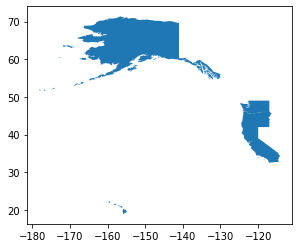

In [13]:
## Code for plotting specific regions (can also be used for states etc)
merged_group[merged_group.SUB_REGION == 'Pacific'].plot()

## Plotting point map

### Excluiding Alaska and Hawaii from the map

df = df.drop(df[(df.state == 'Alaska') & (df.state == 'Hawaii')].index)


df_49 = df.drop(df.index[(df.state == 'Alaska')])
df_48 = df_49.drop(df_49.index[(df_49.state == 'Hawaii')])
df_47 = df_48.drop(df_48.index[(df_48.state == 'District of Columbia')])
print(len(df))
print(len(df_49))
print(len(df_48))
print(len(df_47))

df_47.state.unique()

In [14]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

In [15]:
crs = {'init': 'epsg:4269'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df.head(1)

,Unnamed: 0,incident_id,state,city_or_county,n_killed,n_injured,incident_characteristics,latitude,location_description,longitude,...,Child injured,Gun buy back action,Terrorism Involvement,Officer Involved Shooting - Accidental discharge - no injury required,Mistaken ID,Officer Involved Shooting - subject/suspect/perpetrator suicide by cop,Ghost gun,Political Violence,NAV,geometry
0,0,95289,Michigan,Muskegon,0,0,Shots Fired - No Injuries,43.2301,NaN,-86.2514,...,False,False,False,False,False,False,False,False,False,POINT (-86.25140 43.23010)


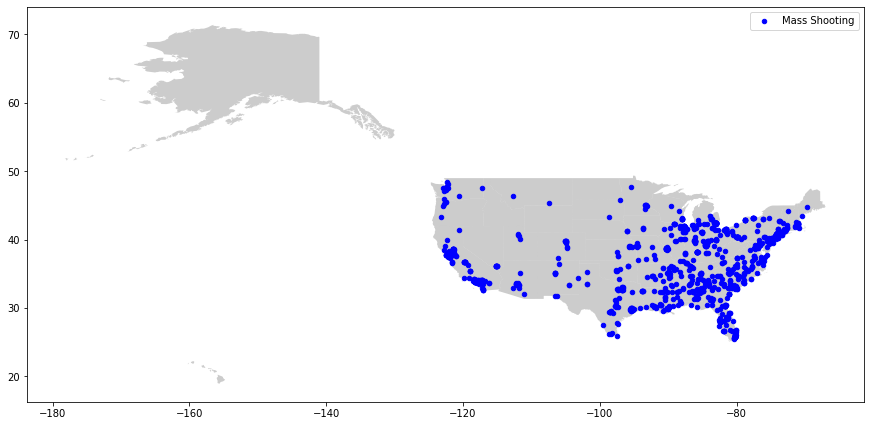

In [16]:
fig, ax = plt.subplots(figsize = (15,15))
usa.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Mass Shooting')
#geo_df[geo_df['incident_id']>= 0].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Incident')
plt.legend()

## Plotting Heatmap with points

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(22.5, 50)

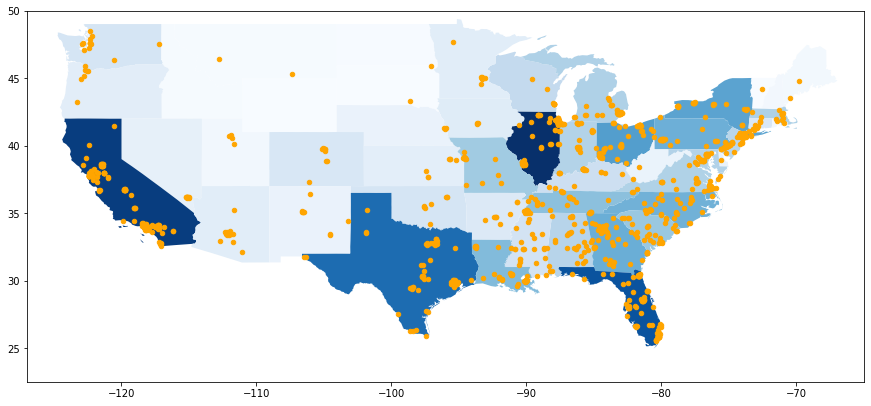

In [17]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'N_incident'

# set the range for the choropleth
vmin, vmax = 472, 17556

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 15))
merged_group_all.plot(column=variable, cmap='Blues', linewidth=0.8, ax = ax)
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'orange', marker = 'o', label = 'Mass Shooting')

plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)

In [18]:
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

# add legend

In [19]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig.savefig("Incidents_figure.pdf", bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(22.5, 50)

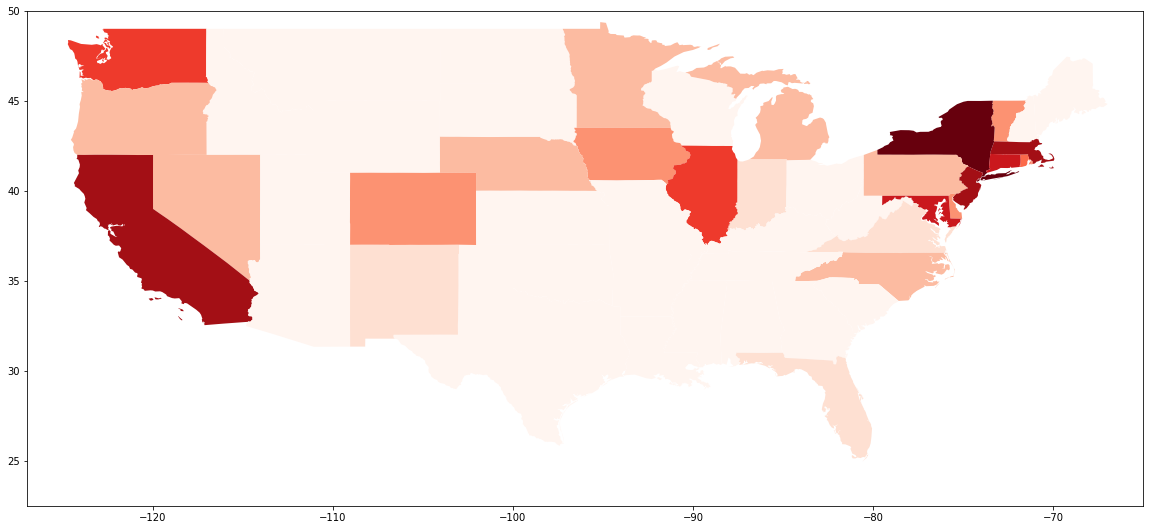

In [20]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'handgun_laws - count'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig_law, ax = plt.subplots(1, figsize=(20, 15))
merged_group_all.plot(column=variable, cmap='Reds', linewidth=0.8, ax = ax)
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)

In [21]:
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

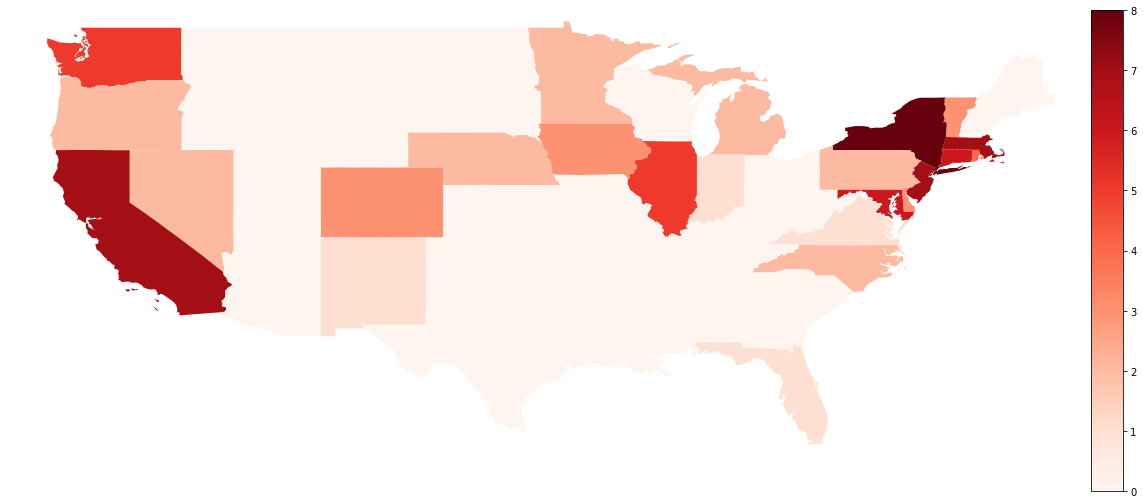

In [22]:
fig_law

In [23]:
fig_law.savefig("law_figure.pdf", bbox_inches='tight')

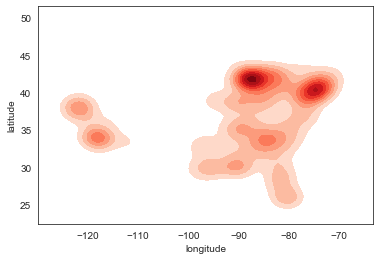

In [24]:
sns.set_style('white')
sns.kdeplot(mass_shootings.longitude, mass_shootings.latitude, kernel='gau', cmap = 'Reds', shade = True, bw='silverman', shade_lowest=False)

(-127.0, -65.0, 22.5, 50.0)

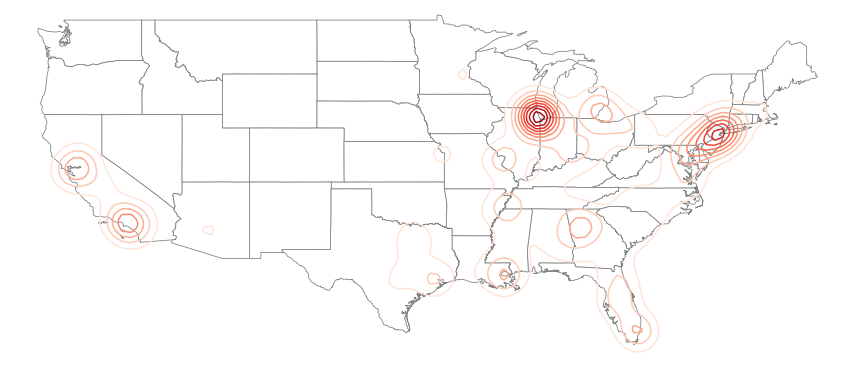

In [25]:
fig_density, ax = plt.subplots(1, figsize=(15, 15))
usa.plot(color='white', edgecolor='grey', linewidth=0.8, ax = ax)
sns.kdeplot(mass_shootings.longitude, mass_shootings.latitude, kernel='biw', cmap = 'Reds', bw=1, ax = ax) #shade_lowest=False shade = True,
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)
ax.axis('off')

(-127.0, -65.0, 22.5, 50.0)

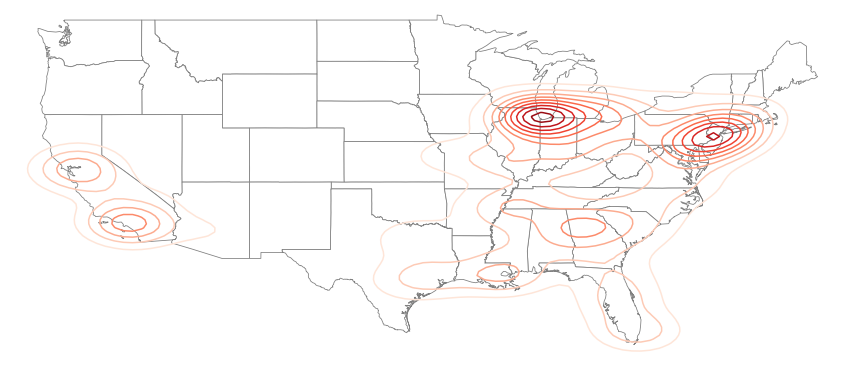

In [26]:
fig_density, ax = plt.subplots(1, figsize=(15, 15))
usa.plot(color='white', edgecolor='grey', linewidth=0.8, ax = ax)
sns.kdeplot(mass_shootings.longitude, mass_shootings.latitude, kernel='biw', cmap = 'Reds', bw='silverman', ax = ax) #shade_lowest=False shade = True,
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)
ax.axis('off')

In [27]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig_density.savefig("density_mass_shootings.pdf", bbox_inches='tight')

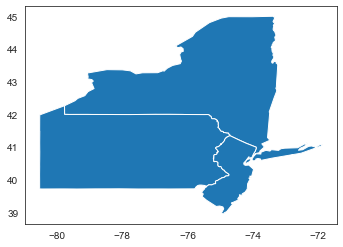

In [54]:
merged_group[merged_group.SUB_REGION == 'Middle Atlantic'].plot()

In [51]:
merged_group.SUB_REGION.unique

<bound method Series.unique of 0                Pacific
1                Pacific
2               Mountain
3            New England
4     West North Central
5     West North Central
6               Mountain
7     East North Central
8               Mountain
9            New England
10    West North Central
11               Pacific
12           New England
13    West North Central
14           New England
15    West North Central
16       Middle Atlantic
17       Middle Atlantic
18           New England
19           New England
20       Middle Atlantic
21    East North Central
22              Mountain
23              Mountain
24               Pacific
25    East North Central
26    East North Central
27        South Atlantic
28        South Atlantic
29        South Atlantic
30        South Atlantic
31              Mountain
32    East South Central
33    West North Central
34        South Atlantic
35    West North Central
36              Mountain
37    West South Central
38        South Atl